In [1]:
# Mount "My Drive" into /content/drive
from google.colab import drive

google_drive_dir = "Final_Project_DL"  # @param
#bml-notebooks/
drive.mount('/content/drive')

mount_point = "/content/drive/MyDrive/{}".format(google_drive_dir)

# Change the root directory to your mount_point
%cd '$mount_point'

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1BOvFtzoVhfYNe70lBGxYzhPlDElSrazo/Final_Project_DL


# <span style="color: royalblue;">Load Data</span>
Load the image data with labels.

In [2]:
import numpy as np
from src.loadData import loadFer2013
from keras.utils import to_categorical


In [3]:
emotions = {0: 'Angry', 1:'Disgust', 2:'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
class_names = list(emotions.values())
class_names

['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [4]:
X_train,X_val,X_test,y_train,y_val,y_test = loadFer2013('fer2013/icml_face_data.csv')

y_train_onehot = to_categorical(y_train)
y_val_onehot = to_categorical(y_val)
y_test_onehot = to_categorical(y_test)

In [5]:
X_train.shape

(28623, 48, 48)

#Preprocessing

In [6]:
def preprocessX(X):
    return np.expand_dims(X,axis=-1)

X_processed_val = preprocessX(X_val)
X_processed_test = preprocessX(X_test)


#Training

In [7]:
import keras
from keras.preprocessing import image
from keras import applications as keras_applications

In [8]:
!pip install keras_applications
!pip install git+https://github.com/rcmalli/keras-vggface.git

     |████████████████████████████████| 51kB 4.6MB/s 
  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-5wdl3ihn
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-5wdl3ihn
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8310 sha256=d8183500f9c7472cb0e2ddad5431e57de49c157540ba2aac503dbb32ba15cb88
  Stored in directory: /tmp/pip-ephem-wheel-cache-rwz7l5fn/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [9]:
from keras_vggface.vggface import VGGFace
from keras_vggface import utils

In [10]:
from copy import deepcopy as copy

def smooth_labels(y, smooth_factor):
    '''Convert a matrix of one-hot row-vector labels into smoothed versions.

    # Arguments
        y: matrix of one-hot row-vector labels to be smoothed
        smooth_factor: label smoothing factor (between 0 and 1)

    # Returns
        A matrix of smoothed labels.
    '''
    assert len(y.shape) == 2, 'input should be a batch of one-hot-encoded data'
    y2 = copy(y)
    if 0 <= smooth_factor <= 1:
        # label smoothing ref: https://www.robots.ox.ac.uk/~vgg/rg/papers/reinception.pdf
        y2 *= 1 - smooth_factor
        y2 += smooth_factor / y.shape[1]
    else:
        raise Exception(
            'Invalid label smoothing factor: ' + str(smooth_factor))
    return y2

In [11]:
from keras.utils import Sequence
from keras.utils import to_categorical
import cv2
from math import floor

class data_sequence(Sequence):
    '''
      yield sequence of data
      features -- list of features
      labels -- list of labels
      target_channels {int} -- 1 (gray) or 3(RGB)
    '''
    def __init__(self, features, labels, batch_size=128, target_dim=(224,224), 
                 n_classes=7, shuffle=True, smooth=0.0, ver=2):
        'Initialization'
        assert len(features)==len(labels), 'number of feature and labels not consistent'
        self.features = features
        self.labels = labels
        self.batch_size = batch_size
        self.target_dim = target_dim
        self.target_channels = 3
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.smooth = smooth
        self.sample_count = len(labels)
        self.indexes = np.arange(self.sample_count)
        self.on_epoch_end()
        self.ver = ver
#         self.verbose = verbose

    def __len__(self):
        'Denotes the number of batches per epoch'
        return floor(self.sample_count / self.batch_size)

    def __gray2RGB__(self,x):
      if len(x.shape)==2:
        return np.stack((x,x,x),-1)
      else:
        assert len(x.shape)==3
        if len(x[0,0,:]) == 1:
          return np.stack((x[:,:,0],x[:,:,0],x[:,:,0]),-1)
        else:
          assert len(x[0,0,:])==self.target_channels
      return x


    def __getitem__(self, idx):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        X = np.empty((self.batch_size, *self.target_dim, self.target_channels))
        Y = np.empty((self.batch_size, self.n_classes))
        for i,ind in enumerate(indexes):
          x = self.features[ind]
          # resize image to the target size 
          x = cv2.resize(x,self.target_dim,interpolation=cv2.INTER_CUBIC)
          x = self.__gray2RGB__(x)
          X[i] = utils.preprocess_input(x, version=self.ver) # or version=2 for VGGFace2 ResNet50  
          y = self.labels[ind]
          if isinstance(y,int):
            Y[i]=to_categorical(y,7)
          else:
            assert len(y)==self.n_classes
            Y[i]=y
        X = np.array(X)
        Y = np.array(Y)
        if self.smooth > 0.0:
          smooth_labels(Y, self.smooth)
        return X,Y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

#Model

In [12]:
model = keras.models.load_model('Final_model/VGGFACE2_V1_RandomOverSampling.h5')

In [13]:
model_vggface1 = keras.models.load_model('Final_model/VGGFACE1.h5')

In [ ]:
val_sequence  = data_sequence(X_processed_val, y_val_onehot, batch_size=37,target_dim=(224,224),n_classes=7,shuffle=False,smooth=0.0,ver=2)

In [14]:
test_sequence  = data_sequence(X_processed_test, y_test_onehot, batch_size=37,target_dim=(224,224),n_classes=7,shuffle=False,smooth=0.0,ver=2)


In [ ]:
y_pred_v2 = model.predict(val_sequence)

In [ ]:
y_pred_v1 = model_vggface1.predict(val_sequence)


In [19]:
from sklearn.metrics import accuracy_score


In [ ]:
y_pred = (y_pred_v1+y_pred_v2)/2
y_pred = np.argmax(y_pred, axis=-1)

In [ ]:
print(accuracy_score(y_pred,y_val))


0.7283365840066871


#test data

In [15]:
y_pred_v2 = model.predict(test_sequence)

In [16]:
y_pred_v1 = model_vggface1.predict(test_sequence)

In [17]:
y_pred = (y_pred_v1*+y_pred_v2)/2
y_pred = np.argmax(y_pred, axis=-1)

In [20]:
print(accuracy_score(y_pred,y_test))


0.7470047366954583


In [35]:
print(y_pred[:10])
print(y_test[:10])

[0 2 4 0 2 0 6 3 2 3]
[0 5 6 4 2 0 4 3 0 3]


(-0.5, 47.5, 47.5, -0.5)

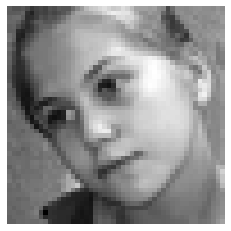

In [37]:
import matplotlib.pyplot as plt

plt.imshow(X_test[6].astype(np.uint8),cmap='gray')
plt.axis('off')

In [39]:
emotions[4]

'Sad'

In [ ]:
import pandas as pd
import tensorflow as tf

confusion_matrix = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()
confusion_matrix = np.around(confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis], decimals=2)

confusion_matrix = pd.DataFrame(confusion_matrix,
                                index = class_names, 
                                columns = class_names)

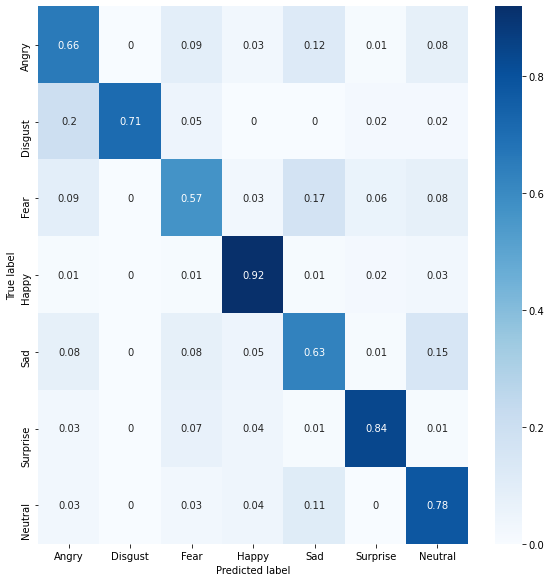

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()